# Eye Spy: An Image Classifier for Headshot Photographers

## Introduction

- I have a side business as a photographer, focusing on headshot photography for film and theatre actors.
- Headshot photographers will typically take 300-600 photographers in every session. Invariably, the subject is blinking, or has partially closed eyes in some of those photographs.
- After every session, I manually edit out these photographs before sending them to the client, which can take 30 minutes to an hour for each session.
- I was considering hiring an assistant, but I wanted to see if I could create a deep learning algorithm to save me time and expense.

## Objective

To build a deep learning model that correctly classifies images where the subject is blinking with 90% accuracy.

In [189]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import cv2
import IPython
import platform
import sklearn

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard

import kerastuner as kt
import pickle

## A. Import Images

> I manually labelled photographs from my own collection of archived sessions, splitting them into EYES_BLINK and EYES_OPEN groups

In [85]:
DATADIR = "/storage/images"

CATEGORIES = ["eyes_blink", "eyes_open"]

In [86]:
imdir1 = '/storage/images/eyes_open/'
imdir2 = '/storage/images/eyes_blink/'
imfile = '1.jpg'

img_array1 = cv2.imread(os.path.join(imdir1, imfile), cv2.IMREAD_GRAYSCALE)
img_array2 = cv2.imread(os.path.join(imdir2, imfile), cv2.IMREAD_GRAYSCALE)

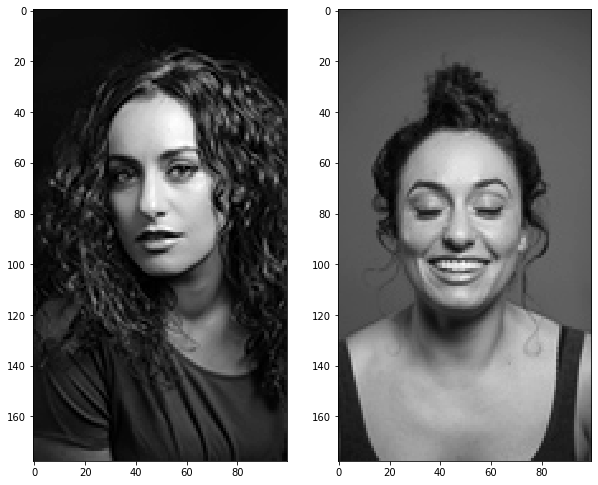

In [87]:
fig, ax = plt.subplots(1,2, figsize=(10, 10)) 
ax[0].imshow(img_array1, cmap='gray')
ax[1].imshow(img_array2, cmap='gray')
plt.show()

In [88]:
training_data = []

def create_training_data():
    for category in CATEGORIES:

        path = os.path.join(DATADIR, category)  # create path
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=eyes_open, 1=eyes_blink

        for img in tqdm(os.listdir(path)):  # iterate over each image
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (100, 178))
                training_data.append([new_array, class_num])  
            except Exception as e:  
                pass

create_training_data()

print(len(training_data))

100%|██████████| 500/500 [00:00<00:00, 757.42it/s]

998


In [89]:
import random

random.shuffle(training_data)

In [90]:
for sample in training_data[:10]:
    print(sample[1])

1
0
1
0
1
1
0
1
0
0


In [91]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, 178, 100, 1))

X = np.array(X).reshape(-1, 178, 100, 1)

y = np.array(y)

[[[[ 7]
   [ 8]
   [ 8]
   ...
   [ 9]
   [ 9]
   [ 9]]

  [[ 7]
   [ 8]
   [ 8]
   ...
   [ 9]
   [ 9]
   [ 9]]

  [[ 7]
   [ 8]
   [ 8]
   ...
   [ 9]
   [ 9]
   [ 9]]

  ...

  [[21]
   [24]
   [24]
   ...
   [31]
   [31]
   [32]]

  [[21]
   [22]
   [23]
   ...
   [31]
   [31]
   [30]]

  [[21]
   [22]
   [23]
   ...
   [31]
   [31]
   [31]]]]


In [94]:
#Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state = 42)

### B. Create Initial Model

In [97]:
X_train = X_train/255.0

model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  

model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=16, epochs=3, validation_data=(X_test, y_test))

Epoch 1/3
44/44 [==============================] - 52s 1s/step - loss: 0.9368 - accuracy: 0.6304 - val_loss: 59.0214 - val_accuracy: 0.7267
Epoch 2/3
44/44 [==============================] - 51s 1s/step - loss: 0.5641 - accuracy: 0.7235 - val_loss: 83.4531 - val_accuracy: 0.5533
Epoch 3/3
44/44 [==============================] - 51s 1s/step - loss: 0.4858 - accuracy: 0.7894 - val_loss: 22.3168 - val_accuracy: 0.7767


In [98]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 176, 98, 256)      2560      
_________________________________________________________________
activation_18 (Activation)   (None, 176, 98, 256)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 88, 49, 256)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 86, 47, 256)       590080    
_________________________________________________________________
activation_19 (Activation)   (None, 86, 47, 256)       0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 43, 23, 256)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 253184)           

In [99]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.817, Test: 0.777


In [163]:
# predict probabilities for test set
y_probs = model.predict(X_test)
# predict crisp classes for test set
y_pred = model.predict_classes(X_test)

In [164]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred )
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred )
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

Accuracy: 0.776667
Precision: 0.778523
Recall: 0.773333
F1 score: 0.775920


### C. Tune Hyperparameters

In [183]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(178, 100)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])

  return model

In [184]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3)


INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [185]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [186]:
tuner.search(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 256 and the optimal learning rate for the optimizer
is 0.0001.



### D. Create Tuned Model

In [187]:
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test))

Epoch 1/10
22/22 [==============================] - 0s 18ms/step - loss: 0.8076 - accuracy: 0.6433 - val_loss: 105.8097 - val_accuracy: 0.6000
Epoch 2/10
22/22 [==============================] - 0s 12ms/step - loss: 0.6850 - accuracy: 0.6891 - val_loss: 73.3507 - val_accuracy: 0.6967
Epoch 3/10
22/22 [==============================] - 0s 12ms/step - loss: 0.5746 - accuracy: 0.7135 - val_loss: 56.0332 - val_accuracy: 0.7233
Epoch 4/10
22/22 [==============================] - 0s 12ms/step - loss: 0.5158 - accuracy: 0.7421 - val_loss: 54.8910 - val_accuracy: 0.7500
Epoch 5/10
22/22 [==============================] - 0s 12ms/step - loss: 0.4663 - accuracy: 0.7665 - val_loss: 44.2767 - val_accuracy: 0.8000
Epoch 6/10
22/22 [==============================] - 0s 12ms/step - loss: 0.4569 - accuracy: 0.7951 - val_loss: 51.8614 - val_accuracy: 0.7600
Epoch 7/10
22/22 [==============================] - 0s 12ms/step - loss: 0.4522 - accuracy: 0.7966 - val_loss: 43.2432 - val_accuracy: 0.7900
Epoch

In [195]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 17800)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4557056   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 4,559,626
Trainable params: 4,559,626
Non-trainable params: 0
_________________________________________________________________


In [198]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.857, Test: 0.790


In [199]:
# predict probabilities for test set
y_probs = model.predict(X_test)
# predict crisp classes for test set
y_pred = model.predict_classes(X_test)

In [200]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred )
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred )
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

Accuracy: 0.790000
Precision: 0.773585
Recall: 0.820000
F1 score: 0.796117


### E. Save Model and Data

In [196]:
model.save('Models/tuned_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Models/tuned_model/assets
